In [4]:
import pickle
import numpy as np

demodir = '/home/anton/Documents/Tulane/Research/ImageNomer/data/UKB2'
demof = f'{demodir}/demographics.pkl'
fcdir = f'{demodir}/conn'

fc = []
ages = []

demo = pickle.load(open(demof, 'rb'))

for sub, age in demo['26258-0.0'].items():
    try:
        r2 = np.load(f'{fcdir}/{sub}_task-20227-2_fc.npy')
        # r3 = np.load(f'{fcdir}/{sub}_task-20227-3_fc.npy')
        # w2 = np.load(f'{fcdir}/{sub}_task-20249-2_fc.npy')
        # w3 = np.load(f'{fcdir}/{sub}_task-20249-3_fc.npy')
        fc.append(r2)
        ages.append(age)
    except:
        pass

fc = np.stack(fc)
ages = np.stack(ages)

# print(list(demo.keys()))

print([a.shape for a in [fc, ages]])

[(39520, 34716), (39520,)]


In [6]:
import numpy as np
import scipy.stats as stats

def corr_feats(feat, var, typ='Pearson', bonf=True):
    feat = feat - np.mean(feat, axis=0, keepdims=True)
    var = var - np.mean(var)
    if typ == 'Spearman':
       # Convert to ranks
       feat = np.argsort(feat, axis=0)
       var = np.argsort(var)
    # Calculate correlation
    sigma_fv = np.einsum('ab,a->b',feat,var)
    sigma_ff = np.einsum('ab,ab->b',feat,feat)
    sigma_vv = np.einsum('a,a->',var,var)
    rho = sigma_fv/(sigma_ff*sigma_vv)**0.5
    # Sometimes happens with SNPs
    rho[np.isnan(rho)] = 0
    # Get t distribution
    n = feat.shape[0]
    m = feat.shape[1]
    df = n-2
    t = rho*(df/(1-rho**2))**0.5
    t[t < 0] = -t[t < 0]
    # Convert to 2-sided p value
    p = (1-stats.t.cdf(t, df))*2
    # Bonferroni correction
    if bonf:
        p *= m
    # Clamp to prevent huge p values
    p[p > 1] = 1
    p[p < 1e-5] = 1e-5
    return rho, np.log10(p), df

im, pim, df = corr_feats(fc, ages)
print('Done')

Done


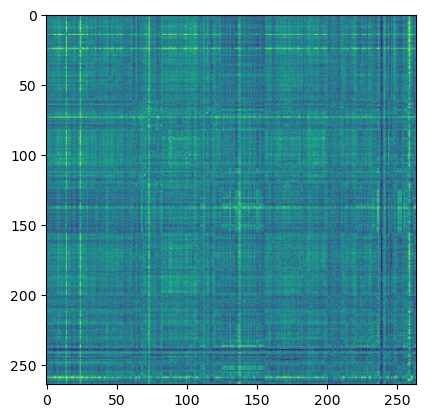

In [14]:
import matplotlib.pyplot as plt

def d_from_vec(fc):
    n = fc.size
    return int(round((1+(1+8*n)**0.5)/2))

def vec2mat(fc, fillones=True):
    d = d_from_vec(fc) 
    a,b = np.triu_indices(d,1)
    mat = np.zeros((d,d))
    mat[a,b] = fc
    mat += mat.T
    ones = np.arange(d)
    if fillones:
        mat[ones,ones] = 1
    return mat

plt.imshow(vec2mat(im, fillones=False))
plt.show()

In [13]:
sm = np.sum(vec2mat(-pim), axis=0)
idcs = np.argsort(sm)[::-1]
print(idcs[:5])

[239  24  14 259  73]
